# Intro to Neural Networks

# Setup Environment and Load Necessary Packages (5%)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical

2.1.0


Using TensorFlow backend.


# Data Preparation (40%)

In [2]:
bank_df = pd.read_csv("bank.csv")

In [3]:
bank_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
bank_df.shape

(10000, 14)

In [5]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# Set RowNumber as index
bank_df.set_index(keys="RowNumber",inplace=True)
bank_df.shape

(10000, 13)

# Drop the columns which are unique for all users like IDs (2.5 points)

In [7]:
bank_df.drop(labels=["CustomerId", "Surname"], axis=1, inplace=True)
bank_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
numericalFeatures = bank_df.select_dtypes(exclude=object).columns
numericalFeatures

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

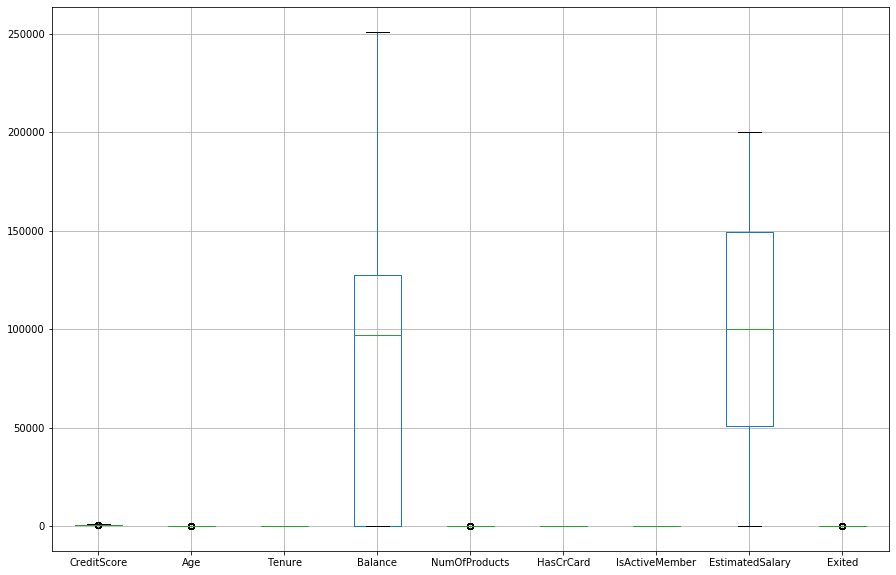

In [9]:
plt.figure(figsize=(15,10))
bank_df.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F044D6D68>,
      dtype=object)

<Figure size 1080x720 with 0 Axes>

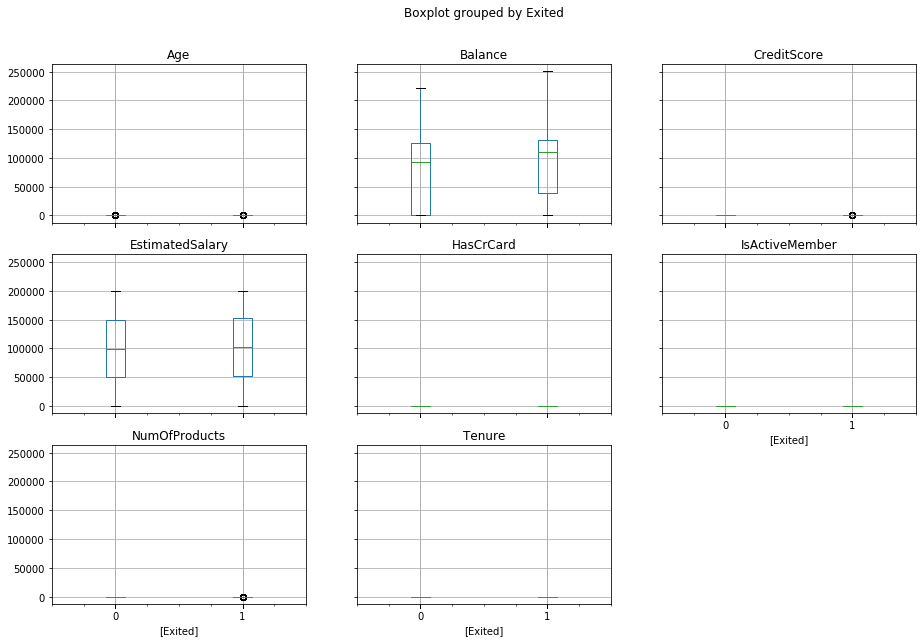

In [10]:
plt.figure(figsize=(15,10))
bank_df.boxplot(by="Exited", figsize=(15,10), layout=(3,3))

### From boxplot above its evident that no outlier present. Boxplot does not show any outliers hence I am using interquartile range method to figure out outliers.

In [11]:
# Check for NULL
print("Number of NULL value: ",sum([True for index, row in bank_df.iterrows() if any(row.isnull())]))

Number of NULL value:  0


In [12]:
bank_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [13]:
# Label Encoding Age to buckets
for index, row in bank_df.iterrows():
    if (row['Age'] >=18 and row['Age']<24):
        bank_df.at[index,'Age'] = 1
    elif (row['Age']>=24 and row['Age']<30):
        bank_df.at[index,'Age'] =  2
    elif (row['Age'] >=30 and row['Age']<40):
        bank_df.at[index,'Age'] =  3
    elif (row['Age'] >=40 and row['Age']<50):
        bank_df.at[index,'Age'] =  4
    elif (row['Age'] >=50 and row['Age']<60):
        bank_df.at[index,'Age'] =  5
    elif (row['Age'] >=60 and row['Age']<70):
        bank_df.at[index,'Age'] =  6
    elif (row['Age'] >=70):
        bank_df.at[index,'Age'] =  7

In [14]:
catogrical_feat = bank_df.select_dtypes(include=object)

In [15]:
labelencoder= LabelEncoder()
bank_df["Geography"] = labelencoder.fit_transform(bank_df["Geography"])
bank_df["Gender"] = labelencoder.fit_transform(bank_df["Gender"])
bank_df["Age"] = labelencoder.fit_transform(bank_df["Age"])
bank_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,0,0,3,2,0.00,1,1,1,101348.88,1
2,608,2,0,3,1,83807.86,1,0,1,112542.58,0
3,502,0,0,3,8,159660.80,3,1,0,113931.57,1
4,699,0,0,2,1,0.00,2,0,0,93826.63,0
5,850,2,0,3,2,125510.82,1,1,1,79084.10,0


In [16]:
cat_feat = ["Geography", "Gender", "Age"]

In [17]:
bank_df = pd.get_dummies(bank_df, columns=cat_feat)

In [18]:
bank_df.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_0,Geography_1,Geography_2,Gender_0,Gender_1,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
RowNumber,,,,,,,,,,,,,,,,,,,,
1,619,2,0.00,1,1,1,101348.88,1,1,0,0,1,0,0,0,0,1,0,0,0
2,608,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0,0,0,0,1,0,0,0
3,502,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0,0,0,0,1,0,0,0
4,699,1,0.00,2,0,0,93826.63,0,1,0,0,1,0,0,0,1,0,0,0,0
5,850,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0,0,0,0,1,0,0,0


In [19]:
bank_df_corr = bank_df.corr()
bank_df_corr

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_0,Geography_1,Geography_2,Gender_0,Gender_1,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
CreditScore,1.000000,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,-0.008928,0.005538,0.004780,0.002857,-0.002857,0.006740,-0.000462,0.010167,-0.009018,-0.013321,-0.005192,0.021518
Tenure,0.000842,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.002848,-0.000567,0.003868,-0.014733,0.014733,0.016154,0.006358,-0.005764,0.000432,-0.004189,-0.006516,0.000586
Balance,0.006268,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,-0.231329,0.401110,-0.134892,-0.012087,0.012087,-0.005808,-0.018637,-0.019870,0.019026,0.035337,0.004974,-0.017080
NumOfProducts,0.012238,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.001230,-0.010419,0.009039,0.021859,-0.021859,0.001634,0.021491,0.013787,-0.011758,-0.026089,-0.010701,0.001325
HasCrCard,-0.005458,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.002467,0.010577,-0.013480,-0.005766,0.005766,-0.005305,0.012046,0.011461,-0.008483,-0.019533,-0.001804,0.006242
IsActiveMember,0.025651,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.003317,-0.020486,0.016732,-0.022544,0.022544,0.002925,-0.006435,-0.023260,-0.057591,0.034364,0.092511,0.092243
EstimatedSalary,-0.001384,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.003332,0.010297,-0.006482,0.008112,-0.008112,0.004787,0.003947,-0.022471,0.035756,-0.015800,-0.007656,-0.007034
Exited,-0.027094,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,-0.104955,0.173488,-0.052667,0.106512,-0.106512,-0.056293,-0.124912,-0.206508,0.154028,0.273236,0.072681,-0.032085
Geography_0,-0.008928,-0.002848,-0.231329,0.001230,0.002467,0.003317,-0.003332,-0.104955,1.000000,-0.580359,-0.575418,-0.006772,0.006772,0.001179,0.024941,0.028612,-0.032149,-0.038139,0.008395,0.003753
Geography_1,0.005538,-0.000567,0.401110,-0.010419,0.010577,-0.020486,0.010297,0.173488,-0.580359,1.000000,-0.332084,0.024628,-0.024628,-0.016315,-0.018549,-0.043467,0.043625,0.048287,-0.012247,0.002107


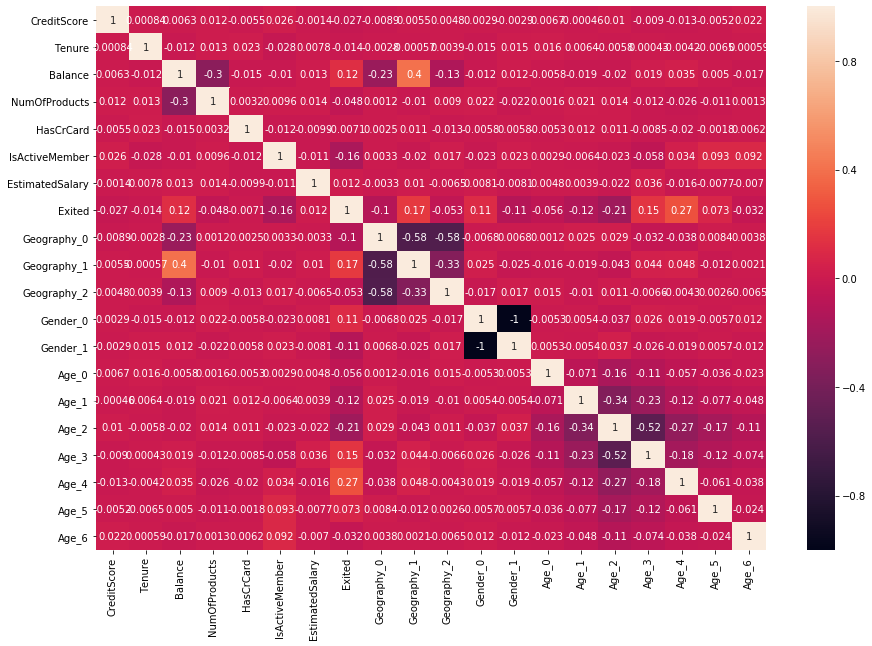

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(bank_df_corr, annot=True)

# Check for imbalance in data

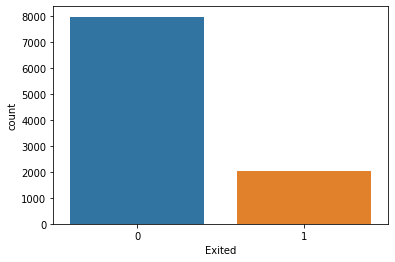

In [21]:
sns.countplot(bank_df["Exited"])

### Above count plot show that imbalance is present in data. Over sampling or under sampling can be used to remove imbalance from data.

In [22]:
X = bank_df.drop("Exited",axis=1)
Y = bank_df["Exited"]

In [23]:
# Encode target variable
Y = to_categorical(Y, num_classes = 2 )

In [24]:
X.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_0,Geography_1,Geography_2,Gender_0,Gender_1,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
RowNumber,,,,,,,,,,,,,,,,,,,
1,619,2,0.00,1,1,1,101348.88,1,0,0,1,0,0,0,0,1,0,0,0
2,608,1,83807.86,1,0,1,112542.58,0,0,1,1,0,0,0,0,1,0,0,0
3,502,8,159660.80,3,1,0,113931.57,1,0,0,1,0,0,0,0,1,0,0,0
4,699,1,0.00,2,0,0,93826.63,1,0,0,1,0,0,0,1,0,0,0,0
5,850,2,125510.82,1,1,1,79084.10,0,0,1,1,0,0,0,0,1,0,0,0


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [26]:
sc = StandardScaler()

In [27]:
x_train_scaled = sc.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled,columns=x_train.columns)

In [28]:
x_train_scaled.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_0,Geography_1,Geography_2,Gender_0,Gender_1,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
0,-0.097921,-1.036351,1.132494,0.810394,0.641985,0.966835,-0.768624,0.984970,-0.569872,-0.573171,-0.922958,0.922958,-0.181398,-0.396022,1.142325,-0.59539,-0.305907,-0.196014,-0.120995
1,-1.126120,0.697009,-1.199755,0.810394,0.641985,-1.034302,-1.393599,0.984970,-0.569872,-0.573171,-0.922958,0.922958,-0.181398,-0.396022,1.142325,-0.59539,-0.305907,-0.196014,-0.120995
2,-0.622303,0.003665,1.368379,-0.929716,-1.557669,0.966835,-1.497393,0.984970,-0.569872,-0.573171,1.083473,-1.083473,-0.181398,-0.396022,-0.875408,-0.59539,-0.305907,-0.196014,8.264801
3,-1.383170,0.003665,-1.199755,-0.929716,-1.557669,0.966835,0.801015,-1.015259,-0.569872,1.744679,-0.922958,0.922958,-0.181398,-0.396022,-0.875408,-0.59539,3.268967,-0.196014,-0.120995
4,-1.465426,0.697009,1.085727,-0.929716,0.641985,0.966835,0.512914,0.984970,-0.569872,-0.573171,1.083473,-1.083473,-0.181398,-0.396022,-0.875408,-0.59539,-0.305907,5.101669,-0.120995


In [29]:
x_test_scaled = sc.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [30]:
x_test_scaled.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_0,Geography_1,Geography_2,Gender_0,Gender_1,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
0,-0.550329,1.043681,0.891721,-0.929716,0.641985,0.966835,1.612453,-1.015259,1.754780,-0.573171,1.083473,-1.083473,-0.181398,-0.396022,1.142325,-0.595390,-0.305907,-0.196014,-0.120995
1,-1.311196,-1.036351,0.442900,-0.929716,0.641985,-1.034302,0.497962,0.984970,-0.569872,-0.573171,1.083473,-1.083473,-0.181398,-0.396022,-0.875408,1.679572,-0.305907,-0.196014,-0.120995
2,0.570408,1.043681,0.321966,-0.929716,0.641985,0.966835,-0.422285,-1.015259,-0.569872,1.744679,1.083473,-1.083473,-0.181398,-0.396022,-0.875408,1.679572,-0.305907,-0.196014,-0.120995
3,1.413531,-0.343007,0.588268,-0.929716,-1.557669,-1.034302,-0.185381,0.984970,-0.569872,-0.573171,-0.922958,0.922958,-0.181398,-0.396022,1.142325,-0.595390,-0.305907,-0.196014,-0.120995
4,0.570408,0.003665,1.401165,0.810394,0.641985,0.966835,0.618880,-1.015259,1.754780,-0.573171,-0.922958,0.922958,-0.181398,-0.396022,1.142325,-0.595390,-0.305907,-0.196014,-0.120995


# Model Creation (30%)

In [31]:
# Clear previous model
keras.backend.clear_session()

In [32]:
N, D = x_train.shape

In [33]:
model = Sequential()

In [34]:
model.add(Dense(10, input_shape=(D,), activation='relu')) #Input layer
model.add(Dense(20, input_shape=(D,), activation='relu')) #Hidden layer
model.add(Dense(30, input_shape=(D,), activation='relu')) #Hidden layer
model.add(Dense(30, input_shape=(D,), activation='relu')) #Hidden layer
model.add(Dense(20, input_shape=(D,), activation='relu')) #Hidden layer
model.add(Dense(2, input_shape=(D,), activation='softmax')) #Output layer

In [35]:
optimizer = keras.optimizers.SGD(learning_rate=0.1)
#model.compile(optimizer="SGD", loss="binary_crossentropy", metrics=['accuracy'])
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 2,642
Trainable params: 2,642
Non-trainable params: 0
______________________________________________________

# Training and Evaluation (25%)

In [37]:
r = model.fit(x_train_scaled, y_train, validation_data=(x_test_scaled, y_test), epochs=100)

Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 1s 187us/sample - loss: 0.4665 - accuracy: 0.7997 - val_loss: 0.4278 - val_accuracy: 0.8163
Epoch 2/100
7000/7000 [==============================] - 1s 92us/sample - loss: 0.4184 - accuracy: 0.8219 - val_loss: 0.4087 - val_accuracy: 0.8270
Epoch 3/100
7000/7000 [==============================] - 1s 93us/sample - loss: 0.4035 - accuracy: 0.8280 - val_loss: 0.3862 - val_accuracy: 0.8383
Epoch 4/100
7000/7000 [==============================] - 1s 96us/sample - loss: 0.3775 - accuracy: 0.8440 - val_loss: 0.3577 - val_accuracy: 0.8587
Epoch 5/100
7000/7000 [==============================] - 1s 90us/sample - loss: 0.3601 - accuracy: 0.8499 - val_loss: 0.3491 - val_accuracy: 0.8550
Epoch 6/100
7000/7000 [==============================] - 1s 92us/sample - loss: 0.3541 - accuracy: 0.8550 - val_loss: 0.3477 - val_accuracy: 0.8613
Epoch 7/100
7000/7000 [==============================] - 1s 92u

Epoch 56/100
7000/7000 [==============================] - 1s 89us/sample - loss: 0.3243 - accuracy: 0.8654 - val_loss: 0.3737 - val_accuracy: 0.8530
Epoch 57/100
7000/7000 [==============================] - 1s 94us/sample - loss: 0.3224 - accuracy: 0.8647 - val_loss: 0.3677 - val_accuracy: 0.8560
Epoch 58/100
7000/7000 [==============================] - 1s 93us/sample - loss: 0.3230 - accuracy: 0.8647 - val_loss: 0.3613 - val_accuracy: 0.8503
Epoch 59/100
7000/7000 [==============================] - 1s 88us/sample - loss: 0.3223 - accuracy: 0.8649 - val_loss: 0.3675 - val_accuracy: 0.8513
Epoch 60/100
7000/7000 [==============================] - 1s 91us/sample - loss: 0.3219 - accuracy: 0.8680 - val_loss: 0.3619 - val_accuracy: 0.8533
Epoch 61/100
7000/7000 [==============================] - 1s 91us/sample - loss: 0.3218 - accuracy: 0.8633 - val_loss: 0.3628 - val_accuracy: 0.8550
Epoch 62/100
7000/7000 [==============================] - 1s 91us/sample - loss: 0.3214 - accuracy: 0.8650

In [38]:
traning_score = model.evaluate(x_train_scaled, y_train)
print("Training Loss: ", traning_score[0])
print("Training Accuracy: ", traning_score[1])

7000/7000 [==============================] - 0s 44us/sample - loss: 0.2950 - accuracy: 0.8741
Training Loss:  0.2950153032881873
Training Accuracy:  0.8741429


In [39]:
test_score = model.evaluate(x_test_scaled, y_test)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

3000/3000 [==============================] - 0s 42us/sample - loss: 0.3920 - accuracy: 0.8520
Test Loss:  0.3919868064721425
Test Accuracy:  0.852


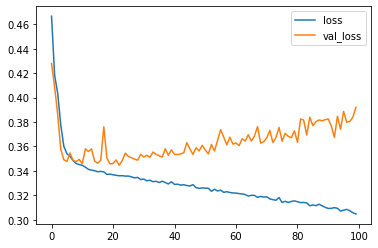

In [40]:
# Plot what's returned by model.fit()
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

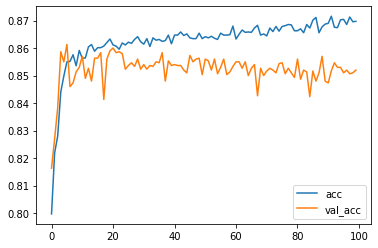

In [41]:
# Plot accuracy
import matplotlib.pyplot as plt
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

#### Above first plot show training, validation loss and 2nd plot show traning and validation accuracy. From these two plots it is evident that model is overfitted. We can apply dropout to reduce over fitting. Next I have created new model(model2) with dropout.

In [42]:
prediction = model.predict(x_test_scaled)

In [43]:
predictedClass = pd.DataFrame(prediction)
predictedClass = predictedClass.idxmax(axis=1)
predictedClass.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [44]:
y_actual = pd.DataFrame(y_test)
y_actual = y_actual.idxmax(axis=1)
y_actual.head()

0    0
1    1
2    0
3    0
4    0
dtype: int64

### Confusion Matrix

In [45]:
confusion_matrix(y_actual, predictedClass)

array([[2211,  168],
       [ 276,  345]], dtype=int64)

### Classification Report

In [46]:
print(classification_report(y_actual, predictedClass))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2379
           1       0.67      0.56      0.61       621

    accuracy                           0.85      3000
   macro avg       0.78      0.74      0.76      3000
weighted avg       0.84      0.85      0.85      3000



## Creating model2 with dropout to avoid overfitting

In [47]:
# Clear previous model
keras.backend.clear_session()

In [48]:
model2 = Sequential()
model2.add(Dense(10, input_shape=(D,), activation='relu')) #Input layer

model2.add(Dropout(0.2))
model2.add(Dense(20, input_shape=(D,), activation='relu')) #Hidden layer

model2.add(Dropout(0.2))
model2.add(Dense(30, input_shape=(D,), activation='relu')) #Hidden layer

model2.add(Dropout(0.2))
model2.add(Dense(30, input_shape=(D,), activation='relu')) #Hidden layer

model2.add(Dropout(0.2))
model2.add(Dense(20, input_shape=(D,), activation='relu')) #Hidden layer

model2.add(Dropout(0.2))
model2.add(Dense(2, input_shape=(D,), activation='softmax')) #Output layer

In [49]:
optimizer = keras.optimizers.SGD(learning_rate=0.1,momentum=0.8)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [50]:
r2 = model2.fit(x_train_scaled, y_train, validation_data=(x_test_scaled, y_test), epochs=100)

Train on 7000 samples, validate on 3000 samples
Epoch 1/100
7000/7000 [==============================] - 2s 240us/sample - loss: 0.4739 - accuracy: 0.7994 - val_loss: 0.4333 - val_accuracy: 0.8043
Epoch 2/100
7000/7000 [==============================] - 1s 107us/sample - loss: 0.4413 - accuracy: 0.8074 - val_loss: 0.4191 - val_accuracy: 0.8197
Epoch 3/100
7000/7000 [==============================] - 1s 106us/sample - loss: 0.4196 - accuracy: 0.8166 - val_loss: 0.3962 - val_accuracy: 0.8173
Epoch 4/100
7000/7000 [==============================] - 1s 106us/sample - loss: 0.4047 - accuracy: 0.8303 - val_loss: 0.4157 - val_accuracy: 0.8033
Epoch 5/100
7000/7000 [==============================] - 1s 106us/sample - loss: 0.3931 - accuracy: 0.8359 - val_loss: 0.3849 - val_accuracy: 0.8333
Epoch 6/100
7000/7000 [==============================] - 1s 107us/sample - loss: 0.3920 - accuracy: 0.8386 - val_loss: 0.3814 - val_accuracy: 0.8207
Epoch 7/100
7000/7000 [==============================] - 1

In [51]:
traning_score = model2.evaluate(x_train_scaled, y_train)
print("Training Loss: ", traning_score[0])
print("Training Accuracy: ", traning_score[1])

7000/7000 [==============================] - 0s 45us/sample - loss: 0.3454 - accuracy: 0.8619
Training Loss:  0.34543017971515655
Training Accuracy:  0.8618571


In [52]:
test_score = model2.evaluate(x_test_scaled, y_test)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

3000/3000 [==============================] - 0s 48us/sample - loss: 0.3550 - accuracy: 0.8500
Test Loss:  0.3550364043712616
Test Accuracy:  0.85


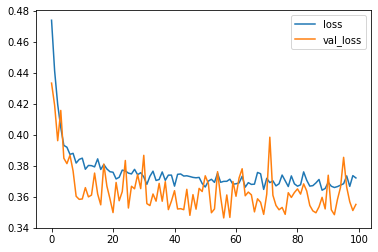

In [53]:
# Plot what's returned by model.fit()
import matplotlib.pyplot as plt
plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()

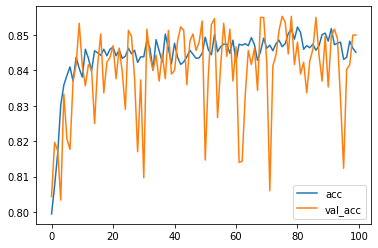

In [54]:
# Plot accuracy
import matplotlib.pyplot as plt
plt.plot(r2.history['accuracy'], label='acc')
plt.plot(r2.history['val_accuracy'], label='val_acc')
plt.legend()

#### Here first plot show training and validation loss of model2 and 2nd plot shows accuracy and validation accuracy of model2. From plotted graph it is evident that overfitting is avoided to some extend. 

### Training loss and test loss very similar. Training accuracy and test accuracy is also very similar, hence model2 is better.

### Prediction

In [55]:
prediction2 = model2.predict(x_test_scaled)
predictedClass2 = pd.DataFrame(prediction2)
predictedClass2 = predictedClass2.idxmax(axis=1)
predictedClass2.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

### Confusion matrix

In [56]:
confusion_matrix(y_actual, predictedClass2)

array([[2241,  138],
       [ 312,  309]], dtype=int64)

### Classification report

In [57]:
print(classification_report(y_actual, predictedClass2))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2379
           1       0.69      0.50      0.58       621

    accuracy                           0.85      3000
   macro avg       0.78      0.72      0.74      3000
weighted avg       0.84      0.85      0.84      3000



# Conclusion

### For model2 Training loss and test loss very similar. Training accuracy and test accuracy is also very similar, hence model2 is better. Overfitting was happening in first model, hence created 2nd model model2 with Dropout to reduce overfitting.

### From aboue count plot its i evident that imbalance is present in data. I have used SMOTE() to remove imbalance but that does not help in increase accuracy. After applying SMOTE() I see accuracy is dropping hence I have removed SMOTE().